In [36]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [37]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [38]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy


# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# Model Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model


In [39]:
student_model1 = load_model('xcep_resnet_d1.h5')

In [40]:
student_model2 = load_model('D:\Mahir\Brain\Brain-Tumor-Classification-Research\Final Experiments\Multi Teacher Single Student\d1\Tiny Xception\Multi_xception_d1.h5')

In [41]:
student_model3 = load_model('D:\Mahir\Brain\Brain-Tumor-Classification-Research\Final Experiments\Multi Teacher Single Student\d1\Tiny Densenet\Multi_Densenet_d1.h5')

In [42]:
# Set seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

In [43]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [44]:
test_data = test_df('D:\Mahir\Datasets\Merged Dataset 1\Testing')

In [45]:
test_data

,Class Path,Class
0,D:\Mahir\Datasets\Merged Dataset 1\Testing\gli...,glioma
1,D:\Mahir\Datasets\Merged Dataset 1\Testing\gli...,glioma
2,D:\Mahir\Datasets\Merged Dataset 1\Testing\gli...,glioma
3,D:\Mahir\Datasets\Merged Dataset 1\Testing\gli...,glioma
4,D:\Mahir\Datasets\Merged Dataset 1\Testing\gli...,glioma
...,...,...
1306,D:\Mahir\Datasets\Merged Dataset 1\Testing\pit...,pituitary
1307,D:\Mahir\Datasets\Merged Dataset 1\Testing\pit...,pituitary
1308,D:\Mahir\Datasets\Merged Dataset 1\Testing\pit...,pituitary
1309,D:\Mahir\Datasets\Merged Dataset 1\Testing\pit...,pituitary


In [46]:
test_path = 'D:\Mahir\Datasets\Merged Dataset 1\Testing'

In [47]:
# Image size
image_size = (160, 160)

# Training batch size
batch_size = 32

# Data preprocessing without any augmentation, only rescaling and validation split
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

# Applying the generator to testing data, only rescaling
test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(160, 160),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  subset='training',  # Uses the other 50% intended for testing
                                                  shuffle=False)

# Define a generator function to convert test_generator to a dataset
def test_gen():
    for i in range(len(test_generator)):
        x, y = test_generator[i]
        yield x, y

# Convert the generator into a tf.data.Dataset
test_dataset = tf.data.Dataset.from_generator(
    test_gen,
    output_signature=(
        tf.TensorSpec(shape=(None, *image_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, test_generator.num_classes), dtype=tf.float32),
    ),
)

# Inspect dataset
print(f"Number of classes: {test_generator.num_classes}")
print(f"Steps per epoch: {len(test_generator)}")


Found 656 images belonging to 4 classes.
Number of classes: 4
Steps per epoch: 21


In [48]:
test_score = student_model1.evaluate(test_dataset, verbose=1)

print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

21/21 [==============================] - 14s 266ms/step - loss: 1.6418 - accuracy: 0.9634
Test Loss: 1.6418
Test Accuracy: 96.34%


In [49]:
test_score = student_model2.evaluate(test_generator, verbose=1)

print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

21/21 [==============================] - 4s 161ms/step - loss: 0.3036 - accuracy: 0.9558 - precision_2: 0.9573 - recall_2: 0.9558
Test Loss: 0.3036
Test Accuracy: 95.58%


In [50]:
test_score = student_model3.evaluate(test_generator, verbose=1)

print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

21/21 [==============================] - 4s 133ms/step - loss: 0.3619 - accuracy: 0.9619 - precision_2: 0.9634 - recall_2: 0.9619
Test Loss: 0.3619
Test Accuracy: 96.19%


In [51]:
import numpy as np

def weighted_ensemble(models, weights, test_dataset, num_samples, batch_size):
    """
    Perform weighted averaging ensemble on multiple models.

    Args:
        models: List of trained models.
        weights: List of weights for the models.
        test_dataset: Test dataset for evaluation.
        num_samples: Total number of samples in the test dataset.
        batch_size: Batch size for the test dataset.

    Returns:
        Accuracy of the ensemble model, true labels, and predicted labels.
    """
    y_true = []
    y_pred_ensemble = []
    batch_count = 0

    # Normalize weights to ensure they sum to 1
    normalized_weights = np.array(weights) / np.sum(weights)

    # Calculate the total number of steps
    steps_per_epoch = np.ceil(num_samples / batch_size).astype(int)

    for x_batch, y_batch in test_dataset:
        batch_count += 1

        # Stop after processing all images
        if batch_count > steps_per_epoch:
            break

        # Collect true labels
        true_labels = np.argmax(y_batch.numpy(), axis=1)
        y_true.extend(true_labels)

        # Get weighted predictions from each model for the current batch
        weighted_predictions = [
            model.predict(x_batch, verbose=0) * weight for model, weight in zip(models, normalized_weights)
        ]

        # Sum the weighted predictions
        combined_predictions = np.sum(weighted_predictions, axis=0)

        # Get the predicted class for each sample
        batch_preds = np.argmax(combined_predictions, axis=1)
        y_pred_ensemble.extend(batch_preds)

        # Print batch progress
        print(f"Batch {batch_count}/{steps_per_epoch}: Processed {len(x_batch)} samples.")
        print(f"  True Labels (first 5): {true_labels[:5]}")
        print(f"  Predicted Labels (first 5): {batch_preds[:5]}")

    # Calculate accuracy
    y_true = np.array(y_true)
    y_pred_ensemble = np.array(y_pred_ensemble)
    accuracy = np.mean(y_true == y_pred_ensemble)

    # Final accuracy
    print(f"\nFinal Weighted Ensemble Test Accuracy: {accuracy:.4f}")

    return accuracy, y_true, y_pred_ensemble


In [52]:
# Define test dataset, models, and weights
num_samples = 2165
batch_size = 32
weights = [0.1, 0.45, 0.45]  # Example weights for 3 models

# Perform weighted ensemble
weighted_accuracy, y_true, y_pred = weighted_ensemble(
    [student_model1, student_model2, student_model3], 
    weights, 
    test_dataset, 
    num_samples, 
    batch_size
)

print(f"Weighted Ensemble Test Accuracy: {weighted_accuracy:.4f}")

Batch 1/68: Processed 32 samples.
  True Labels (first 5): [0 0 0 0 0]
  Predicted Labels (first 5): [0 0 0 0 0]
Batch 2/68: Processed 32 samples.
  True Labels (first 5): [0 0 0 0 0]
  Predicted Labels (first 5): [0 0 0 0 0]
Batch 3/68: Processed 32 samples.
  True Labels (first 5): [0 0 0 0 0]
  Predicted Labels (first 5): [0 0 0 0 0]
Batch 4/68: Processed 32 samples.
  True Labels (first 5): [0 0 0 0 0]
  Predicted Labels (first 5): [0 1 0 0 0]
Batch 5/68: Processed 32 samples.
  True Labels (first 5): [0 0 0 0 0]
  Predicted Labels (first 5): [0 0 0 0 0]
Batch 6/68: Processed 32 samples.
  True Labels (first 5): [1 1 1 1 1]
  Predicted Labels (first 5): [3 1 1 1 1]
Batch 7/68: Processed 32 samples.
  True Labels (first 5): [1 1 1 1 1]
  Predicted Labels (first 5): [1 1 1 1 1]
Batch 8/68: Processed 32 samples.
  True Labels (first 5): [1 1 1 1 1]
  Predicted Labels (first 5): [1 1 1 1 1]
Batch 9/68: Processed 32 samples.
  True Labels (first 5): [1 1 1 1 1]
  Predicted Labels (first

Batch 1/68: Processed 32 samples.
  True Labels (first 5): [0 0 0 0 0]
  Predicted Labels (first 5): [0 0 0 0 0]
Batch 2/68: Processed 32 samples.
  True Labels (first 5): [0 0 0 0 0]
  Predicted Labels (first 5): [0 0 0 0 0]
Batch 3/68: Processed 32 samples.
  True Labels (first 5): [0 0 0 0 0]
  Predicted Labels (first 5): [0 0 0 0 0]
Batch 4/68: Processed 32 samples.
  True Labels (first 5): [0 0 0 0 0]
  Predicted Labels (first 5): [0 1 0 0 0]
Batch 5/68: Processed 32 samples.
  True Labels (first 5): [0 0 0 0 0]
  Predicted Labels (first 5): [0 0 0 0 0]
Batch 6/68: Processed 32 samples.
  True Labels (first 5): [1 1 1 1 1]
  Predicted Labels (first 5): [3 1 1 1 1]
Batch 7/68: Processed 32 samples.
  True Labels (first 5): [1 1 1 1 1]
  Predicted Labels (first 5): [1 1 1 1 1]
Batch 8/68: Processed 32 samples.
  True Labels (first 5): [1 1 1 1 1]
  Predicted Labels (first 5): [1 1 1 1 1]
Batch 9/68: Processed 32 samples.
  True Labels (first 5): [1 1 1 1 1]
  Predicted Labels (first

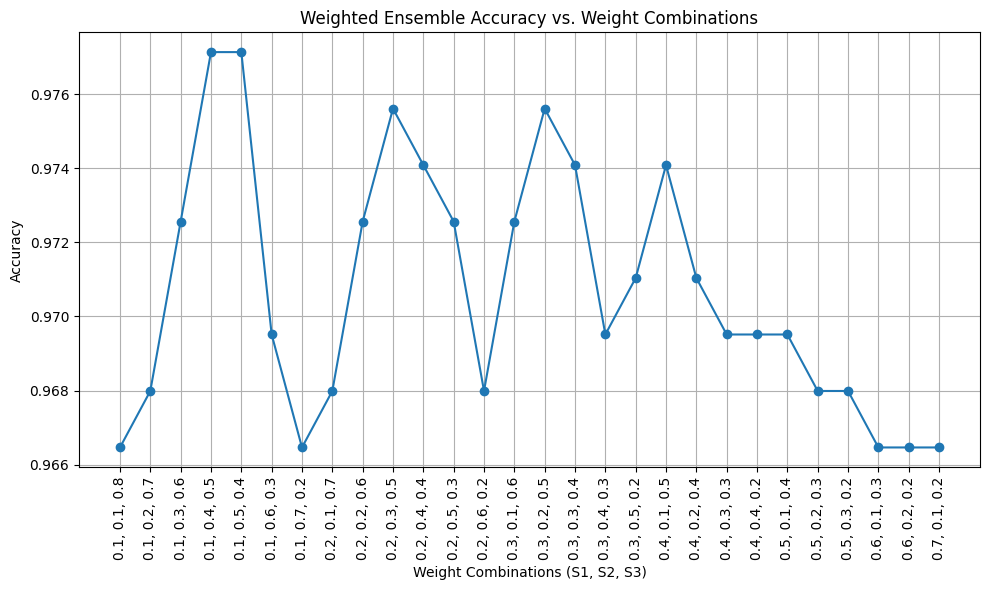


Best Weights: [0.1, 0.4, 0.5], Best Accuracy: 0.9771
Batch 1/68: Processed 32 samples.
  True Labels (first 5): [0 0 0 0 0]
  Predicted Labels (first 5): [0 0 0 0 0]
Batch 2/68: Processed 32 samples.
  True Labels (first 5): [0 0 0 0 0]
  Predicted Labels (first 5): [0 0 0 0 0]
Batch 3/68: Processed 32 samples.
  True Labels (first 5): [0 0 0 0 0]
  Predicted Labels (first 5): [0 0 0 0 0]
Batch 4/68: Processed 32 samples.
  True Labels (first 5): [0 0 0 0 0]
  Predicted Labels (first 5): [0 1 0 0 0]
Batch 5/68: Processed 32 samples.
  True Labels (first 5): [0 0 0 0 0]
  Predicted Labels (first 5): [0 0 0 0 0]
Batch 6/68: Processed 32 samples.
  True Labels (first 5): [1 1 1 1 1]
  Predicted Labels (first 5): [3 1 1 1 1]
Batch 7/68: Processed 32 samples.
  True Labels (first 5): [1 1 1 1 1]
  Predicted Labels (first 5): [1 1 1 1 1]
Batch 8/68: Processed 32 samples.
  True Labels (first 5): [1 1 1 1 1]
  Predicted Labels (first 5): [1 1 1 1 1]
Batch 9/68: Processed 32 samples.
  True L

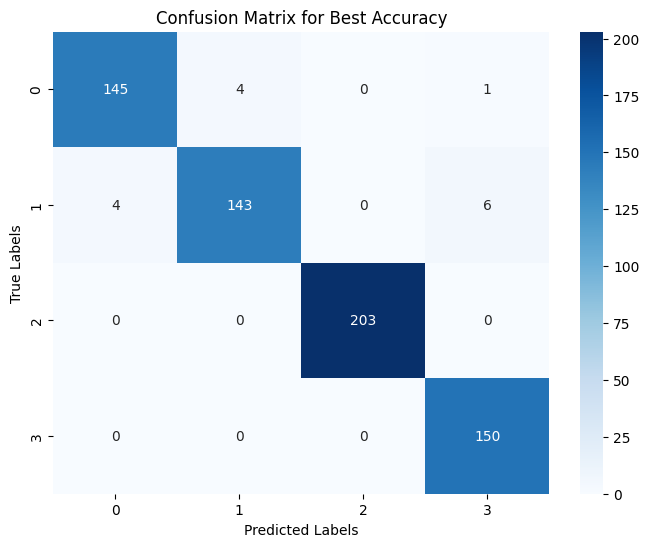


Classification Report for Best Accuracy:
               precision    recall  f1-score   support

           0     0.9732    0.9667    0.9699       150
           1     0.9728    0.9346    0.9533       153
           2     1.0000    1.0000    1.0000       203
           3     0.9554    1.0000    0.9772       150

    accuracy                         0.9771       656
   macro avg     0.9753    0.9753    0.9751       656
weighted avg     0.9773    0.9771    0.9770       656



In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # For saving results to CSV
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Function to perform grid search for weights and plot accuracies
def grid_search_weights(models, test_dataset, num_samples, batch_size, filename="grid_search_results_d1.csv"):
    """
    Perform a grid search to adjust weights and evaluate weighted ensemble accuracy.

    Args:
        models: List of trained models.
        test_dataset: Test dataset for evaluation.
        num_samples: Total number of samples in the test dataset.
        batch_size: Batch size for the test dataset.
        filename: File name to save the results to (default is "grid_search_results.csv").

    Returns:
        Optimal weights and the corresponding accuracy.
    """
    step = 0.1
    best_accuracy = 0
    best_weights = None
    accuracies = []
    weight_combinations = []

    # Loop through all possible weight combinations with a step of 0.1
    for w1 in np.arange(step, 1.1, step):
        for w2 in np.arange(step, 1.1 - w1, step):
            w3 = 1.0 - (w1 + w2)
            if w3 < step or w3 > 1:
                continue

            weights = [w1, w2, w3]
            weight_combinations.append(weights)

            # Perform weighted ensemble
            accuracy, _, _ = weighted_ensemble(models, weights, test_dataset, num_samples, batch_size)
            accuracies.append(accuracy)

            # Update best weights if current accuracy is better
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_weights = weights

            print(f"Weights: {weights}, Accuracy: {accuracy:.4f}")

    # Save the results to a CSV file for later analysis
    results_df = pd.DataFrame({
        "Weight 1": [w[0] for w in weight_combinations],
        "Weight 2": [w[1] for w in weight_combinations],
        "Weight 3": [w[2] for w in weight_combinations],
        "Accuracy": accuracies
    })
    results_df.to_csv(filename, index=False)

    # Plot the accuracies
    plt.figure(figsize=(10, 6))
    x = range(len(accuracies))
    plt.plot(x, accuracies, marker='o')
    plt.xticks(x, [f"{w[0]:.1f}, {w[1]:.1f}, {w[2]:.1f}" for w in weight_combinations], rotation=90)
    plt.xlabel("Weight Combinations (S1, S2, S3)")
    plt.ylabel("Accuracy")
    plt.title("Weighted Ensemble Accuracy vs. Weight Combinations")
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Generate confusion matrix and classification report for the best accuracy
    print(f"\nBest Weights: {best_weights}, Best Accuracy: {best_accuracy:.4f}")
    
    # Perform weighted ensemble with the best weights
    accuracy, y_true, y_pred_ensemble = weighted_ensemble(
        models, best_weights, test_dataset, num_samples, batch_size
    )

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_ensemble)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(cm.shape[0]), yticklabels=np.arange(cm.shape[0]))
    plt.title("Confusion Matrix for Best Accuracy")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Classification Report
    report = classification_report(y_true, y_pred_ensemble, digits=4)
    print("\nClassification Report for Best Accuracy:\n", report)

    return best_weights, best_accuracy

# Example usage
best_weights, best_accuracy = grid_search_weights(
    [student_model1, student_model2, student_model3], 
    test_dataset, 
    num_samples, 
    batch_size
)


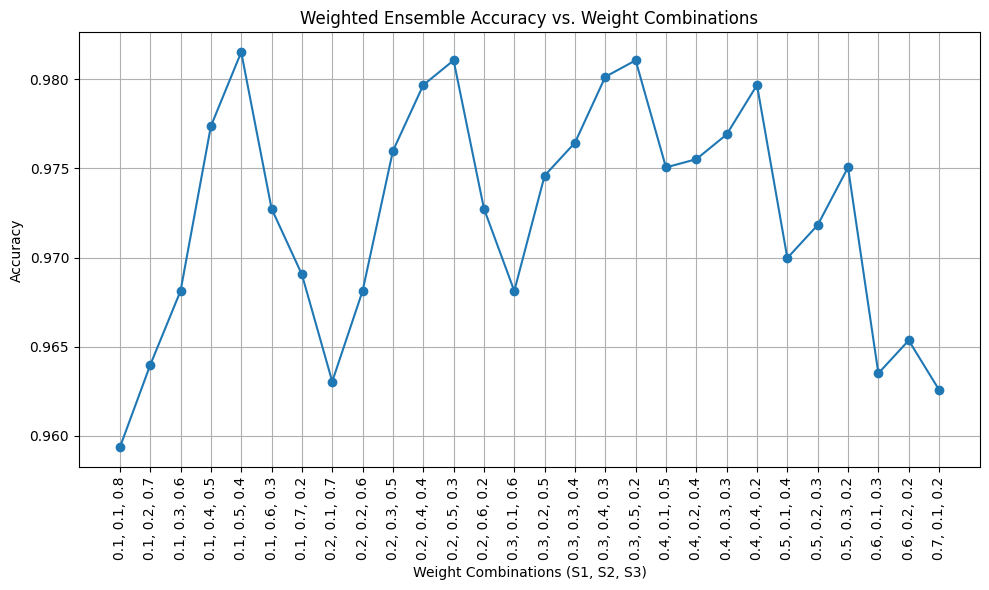

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to load the results from CSV and plot
def load_and_plot_results(filename="grid_search_results_d1.csv"):
    """
    Load grid search results from a CSV file and plot the accuracies.

    Args:
        filename: File name to load the results from (default is "grid_search_results.csv").
    """
    # Load the results from the CSV file
    results_df = pd.read_csv(filename)

    # Plot the accuracies
    plt.figure(figsize=(10, 6))
    x = range(len(results_df))
    plt.plot(x, results_df['Accuracy'], marker='o')

    # Label x-axis with the weight combinations
    plt.xticks(x, [f"{w1:.1f}, {w2:.1f}, {w3:.1f}" for w1, w2, w3 in zip(results_df['Weight 1'], results_df['Weight 2'], results_df['Weight 3'])], rotation=90)
    
    plt.xlabel("Weight Combinations (S1, S2, S3)")
    plt.ylabel("Accuracy")
    plt.title("Weighted Ensemble Accuracy vs. Weight Combinations")
    plt.grid()
    plt.tight_layout()
    plt.show()

# Example usage
load_and_plot_results("grid_search_results_d2.csv")
